<a href="https://colab.research.google.com/github/limited-fion/deep-learning-cw/blob/master/05_cw.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Graphs**

In [1]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
from google.colab import drive
import os
drive.mount('/content/drive')

!wget https://github.com/trishume/OpenTuringCompiler/blob/master/stdlib-sfml/fonts/Times%20New%20Roman.ttf

font_files = fm.findSystemFonts()

# Go through and add each to Matplotlib's font cache.
for font_file in font_files:
    fm.fontManager.addfont(font_file)

# Use your new font on all your plots.
plt.rc('font', family='serif')

def plot_history(history, fileName, metric = None):

  if metric != None:
    fig, axes = plt.subplots(2,1, figsize=(15,10))
    axes[0].plot(history.history[metric])
    try:
      axes[0].plot(history.history['val_'+metric])
      axes[0].legend(['Training', 'Validation'], fontsize=14)
      axes[0].tick_params(axis='x', which='major', labelsize=12)
      axes[0].tick_params(axis='y', which='major', labelsize=12)
    except:
      pass
    axes[0].set_title('Model Accuracy', fontsize = 18)
    axes[0].set_ylabel('Accuracy', fontsize = 14)
    axes[0].set_xlabel('Epoch', fontsize = 14)
    fig.subplots_adjust(hspace=0.35)
    axes[1].plot(history.history['loss'])
    try:
      axes[1].plot(history.history['val_loss'])
      axes[1].legend(['Training', 'Validation'], fontsize=14)
      axes[1].tick_params(axis='x', which='major', labelsize=12)
      axes[1].tick_params(axis='y', which='major', labelsize=12)
    except:
      pass
    axes[1].set_title('Model Loss', fontsize = 18)
    axes[1].set_ylabel('Loss', fontsize = 14)
    axes[1].set_xlabel('Epoch', fontsize = 14)
  else:
    plt.plot(history.history['loss'])
    try:
      plt.plot(history.history['val_loss'])
      plt.legend(['Training', 'Validation'], fontsize=14)
    except:
      pass
    plt.title('Model Loss', fontsize = 18)
    plt.yticks(fontsize = 12)
    plt.xticks(fontsize = 12)
    plt.ylabel('Loss', fontsize = 14)
    plt.xlabel('Epoch', fontsize = 14)

  directory = '/content/drive/MyDrive/dl-cw-05/diagrams/'
  
  if not os.path.exists(directory):
    os.makedirs(directory)

  plt.savefig(os.path.join(directory, fileName))

Mounted at /content/drive
--2023-03-09 19:20:35--  https://github.com/trishume/OpenTuringCompiler/blob/master/stdlib-sfml/fonts/Times%20New%20Roman.ttf
Resolving github.com (github.com)... 192.30.255.113
Connecting to github.com (github.com)|192.30.255.113|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/html]
Saving to: ‘Times New Roman.ttf’

Times New Roman.ttf     [  <=>               ] 137.48K   281KB/s    in 0.5s    

2023-03-09 19:20:36 (281 KB/s) - ‘Times New Roman.ttf’ saved [140776]



# **Task 1**


## Set up libraries and dataset (functions)

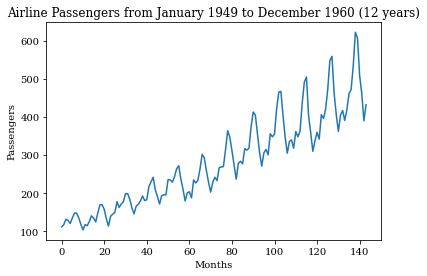

In [81]:
import pandas
import matplotlib.pyplot as plt
from keras.layers.core import Dense, Activation, Dropout
from tensorflow.keras.layers import LSTM
from keras.models import Sequential
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.utils import shuffle
import numpy as np
import math

data = pandas.read_csv('airline-passengers.csv', usecols=[1], engine='python')
plt.plot(data)
plt.xlabel("Months")
plt.ylabel("Passengers")
plt.title("Airline Passengers from January 1949 to December 1960 (12 years)")
plt.show()

def create_dataset(dataset, window_size = 1):
  data_x, data_y = [], []
  for i in range(len(dataset) - window_size - 1):
      sample = dataset[i:(i + window_size), 0]
      data_x.append(sample)
      data_y.append(dataset[i + window_size, 0])
  return(np.array(data_x), np.array(data_y))

def get_predict_and_score(model, X, Y, normalizer):
  # transform the prediction to the original scale.
  pred = normalizer.inverse_transform(model.predict(X))
  # transform also the label to the original scale for interpretability.
  orig_data = normalizer.inverse_transform([Y])
  # calculate RMSE.
  score = math.sqrt(mean_squared_error(orig_data[0], pred[:, 0]))
  return score, pred

def prepare_train_and_predict_data(window_size):
  # convert pandas data frame in numpy array of float.
  data_np = data.values.astype("float32")

  # normalize data with min max normalization
  normalizer = MinMaxScaler(feature_range = (0, 1))
  dataset = normalizer.fit_transform(data_np)

  # Using 70% of data for training, 30% for test.
  TRAINING_PERC = 0.70

  train_size = int(len(dataset) * TRAINING_PERC)
  test_size = len(dataset) - train_size
  train, test = dataset[0:train_size, :], dataset[train_size:len(dataset), :]
  print("Number of samples training set: " + str((len(train))))
  print("Number of samples test set: " + str((len(test))))

  # Create test and training sets for regression with different window sizes.
  train_X, train_Y = create_dataset(train, window_size)
  test_X, test_Y = create_dataset(test, window_size)

  train_X = np.reshape(train_X, (train_X.shape[0], train_X.shape[1], 1))
  test_X = np.reshape(test_X, (test_X.shape[0], test_X.shape[1], 1))

  print("Shape of training inputs: " + str((train_X.shape)))
  print("Shape of training labels: " + str((train_Y.shape)))

  batch_size = 32
  rnn = Sequential()    
  rnn.add(LSTM(16, input_shape = (window_size, 1)))
  rnn.add(Dense(1))
  rnn.compile(loss = "mean_squared_error",  optimizer = "adam", metrics = ['mse'])

  rnn.fit(train_X, train_Y, epochs=500, batch_size=batch_size, validation_data=(test_X, test_Y))

  mse_train, train_predict = get_predict_and_score(rnn, train_X, train_Y, normalizer)
  mse_test, test_predict = get_predict_and_score(rnn, test_X, test_Y, normalizer)

  print("Training data error: %.2f MSE" % mse_train)
  print("Test data error: %.2f MSE" % mse_test)

# **1**


In [7]:
window_size = 1

# convert pandas data frame in numpy array of float.
data_np = data.values.astype("float32")

# normalize data with min max normalization
normalizer = MinMaxScaler(feature_range = (0, 1))
dataset = normalizer.fit_transform(data_np)

# Using 70% of data for training, 30% for test.
TRAINING_PERC = 0.70

train_size = int(len(dataset) * TRAINING_PERC)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size, :], dataset[train_size:len(dataset), :]
print("Number of samples training set: " + str((len(train))))
print("Number of samples test set: " + str((len(test))))

# Create test and training sets for regression with different window sizes.
train_X, train_Y = create_dataset(train, window_size)
test_X, test_Y = create_dataset(test, window_size)

train_X = np.reshape(train_X, (train_X.shape[0], train_X.shape[1], 1))
test_X = np.reshape(test_X, (test_X.shape[0], test_X.shape[1], 1))

print("Shape of training inputs: " + str((train_X.shape)))
print("Shape of training labels: " + str((train_Y.shape)))

batch_size = 32
rnn = Sequential()    
rnn.add(LSTM(16, input_shape = (window_size, 1)))
rnn.add(Dense(1))
rnn.compile(loss = "mean_squared_error",  optimizer = "adam", metrics = ['mse'])

rnn.fit(train_X, train_Y, epochs=500, batch_size=batch_size, validation_data=(test_X, test_Y))

mse_train, train_predict = get_predict_and_score(rnn, train_X, train_Y, normalizer)
mse_test, test_predict = get_predict_and_score(rnn, test_X, test_Y, normalizer)

print("Training data error: %.2f MSE" % mse_train)
print("Test data error: %.2f MSE" % mse_test)

Number of samples training set: 100
Number of samples test set: 44
Shape of training inputs: (98, 1, 1)
Shape of training labels: (98,)
Epoch 1/500
4/4 [==============================] - 2s 144ms/step - loss: 0.0617 - mse: 0.0617 - val_loss: 0.3537 - val_mse: 0.3537
Epoch 2/500
4/4 [==============================] - 0s 13ms/step - loss: 0.0578 - mse: 0.0578 - val_loss: 0.3398 - val_mse: 0.3398
Epoch 3/500
4/4 [==============================] - 0s 20ms/step - loss: 0.0541 - mse: 0.0541 - val_loss: 0.3267 - val_mse: 0.3267
Epoch 4/500
4/4 [==============================] - 0s 12ms/step - loss: 0.0504 - mse: 0.0504 - val_loss: 0.3134 - val_mse: 0.3134
Epoch 5/500
4/4 [==============================] - 0s 12ms/step - loss: 0.0469 - mse: 0.0469 - val_loss: 0.3000 - val_mse: 0.3000
Epoch 6/500
4/4 [==============================] - 0s 13ms/step - loss: 0.0435 - mse: 0.0435 - val_loss: 0.2870 - val_mse: 0.2870
Epoch 7/500
4/4 [==============================] - 0s 11ms/step - loss: 0.0402 - ms

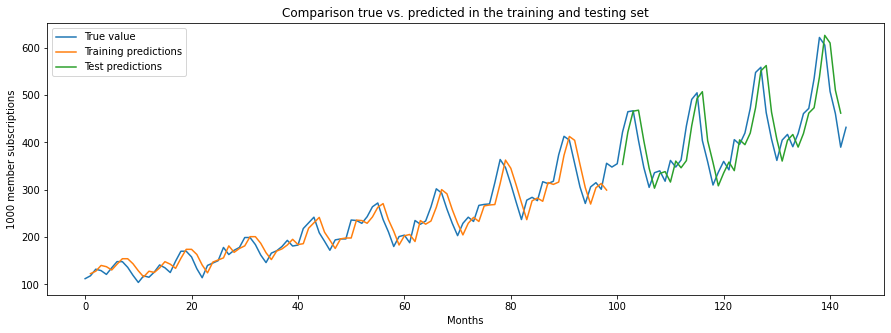

In [8]:
# Training predictions.
train_predictions = np.empty_like(dataset)
train_predictions[:, :] = np.nan
train_predictions[window_size:len(train_predict) + window_size, :] = train_predict

# Test predictions.
test_predictions = np.empty_like(dataset)
test_predictions[:, :] = np.nan
test_predictions[len(train_predict) + (window_size * 2) + 1:len(dataset) - 1, :] = test_predict

# Create the plot.
plt.figure(figsize = (15, 5))
plt.plot(normalizer.inverse_transform(dataset), label = "True value")

plt.plot(train_predictions, label = "Training predictions")
plt.plot(test_predictions, label = "Test predictions")
plt.xlabel("Months")
plt.ylabel("1000 member subscriptions")
plt.title("Comparison true vs. predicted in the training and testing set")
plt.legend()
plt.show()

# **2**

In [9]:
window_size = 2

# convert pandas data frame in numpy array of float.
data_np = data.values.astype("float32")

# normalize data with min max normalization
normalizer = MinMaxScaler(feature_range = (0, 1))
dataset = normalizer.fit_transform(data_np)

# Using 70% of data for training, 30% for test.
TRAINING_PERC = 0.70

train_size = int(len(dataset) * TRAINING_PERC)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size, :], dataset[train_size:len(dataset), :]
print("Number of samples training set: " + str((len(train))))
print("Number of samples test set: " + str((len(test))))

# Create test and training sets for regression with different window sizes.
train_X, train_Y = create_dataset(train, window_size)
test_X, test_Y = create_dataset(test, window_size)

train_X = np.reshape(train_X, (train_X.shape[0], train_X.shape[1], 1))
test_X = np.reshape(test_X, (test_X.shape[0], test_X.shape[1], 1))

print("Shape of training inputs: " + str((train_X.shape)))
print("Shape of training labels: " + str((train_Y.shape)))

batch_size = 32
rnn = Sequential()    
rnn.add(LSTM(16, input_shape = (window_size, 1)))
rnn.add(Dense(1))
rnn.compile(loss = "mean_squared_error",  optimizer = "adam", metrics = ['mse'])

rnn.fit(train_X, train_Y, epochs=500, batch_size=batch_size, validation_data=(test_X, test_Y))

mse_train, train_predict = get_predict_and_score(rnn, train_X, train_Y, normalizer)
mse_test, test_predict = get_predict_and_score(rnn, test_X, test_Y, normalizer)

print("Training data error: %.2f MSE" % mse_train)
print("Test data error: %.2f MSE" % mse_test)

Number of samples training set: 100
Number of samples test set: 44
Shape of training inputs: (97, 2, 1)
Shape of training labels: (97,)
Epoch 1/500
4/4 [==============================] - 2s 138ms/step - loss: 0.0722 - mse: 0.0722 - val_loss: 0.4059 - val_mse: 0.4059
Epoch 2/500
4/4 [==============================] - 0s 12ms/step - loss: 0.0649 - mse: 0.0649 - val_loss: 0.3790 - val_mse: 0.3790
Epoch 3/500
4/4 [==============================] - 0s 12ms/step - loss: 0.0581 - mse: 0.0581 - val_loss: 0.3540 - val_mse: 0.3540
Epoch 4/500
4/4 [==============================] - 0s 13ms/step - loss: 0.0521 - mse: 0.0521 - val_loss: 0.3310 - val_mse: 0.3310
Epoch 5/500
4/4 [==============================] - 0s 13ms/step - loss: 0.0468 - mse: 0.0468 - val_loss: 0.3091 - val_mse: 0.3091
Epoch 6/500
4/4 [==============================] - 0s 18ms/step - loss: 0.0419 - mse: 0.0419 - val_loss: 0.2897 - val_mse: 0.2897
Epoch 7/500
4/4 [==============================] - 0s 12ms/step - loss: 0.0377 - ms

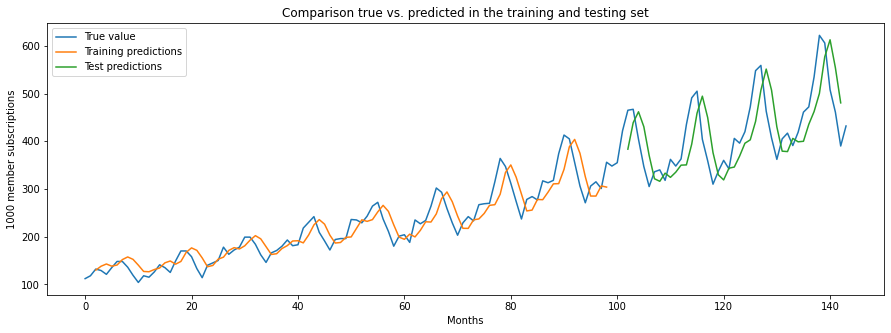

In [10]:
# Training predictions.
train_predictions2 = np.empty_like(dataset)
train_predictions2[:, :] = np.nan
train_predictions2[window_size:len(train_predict) + window_size, :] = train_predict

# Test predictions.
test_predictions2 = np.empty_like(dataset)
test_predictions2[:, :] = np.nan
test_predictions2[len(train_predict) + (window_size * 2) + 1:len(dataset) - 1, :] = test_predict

# Create the plot.
plt.figure(figsize = (15, 5))
plt.plot(normalizer.inverse_transform(dataset), label = "True value")

plt.plot(train_predictions2, label = "Training predictions")
plt.plot(test_predictions2, label = "Test predictions")
plt.xlabel("Months")
plt.ylabel("1000 member subscriptions")
plt.title("Comparison true vs. predicted in the training and testing set")
plt.legend()
plt.show()

# **3**

In [11]:
window_size = 3

# convert pandas data frame in numpy array of float.
data_np = data.values.astype("float32")

# normalize data with min max normalization
normalizer = MinMaxScaler(feature_range = (0, 1))
dataset = normalizer.fit_transform(data_np)

# Using 70% of data for training, 30% for test.
TRAINING_PERC = 0.70

train_size = int(len(dataset) * TRAINING_PERC)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size, :], dataset[train_size:len(dataset), :]
print("Number of samples training set: " + str((len(train))))
print("Number of samples test set: " + str((len(test))))

# Create test and training sets for regression with different window sizes.
train_X, train_Y = create_dataset(train, window_size)
test_X, test_Y = create_dataset(test, window_size)

train_X = np.reshape(train_X, (train_X.shape[0], train_X.shape[1], 1))
test_X = np.reshape(test_X, (test_X.shape[0], test_X.shape[1], 1))

print("Shape of training inputs: " + str((train_X.shape)))
print("Shape of training labels: " + str((train_Y.shape)))

batch_size = 32
rnn = Sequential()    
rnn.add(LSTM(16, input_shape = (window_size, 1)))
rnn.add(Dense(1))
rnn.compile(loss = "mean_squared_error",  optimizer = "adam", metrics = ['mse'])

rnn.fit(train_X, train_Y, epochs=500, batch_size=batch_size, validation_data=(test_X, test_Y))

mse_train, train_predict = get_predict_and_score(rnn, train_X, train_Y, normalizer)
mse_test, test_predict = get_predict_and_score(rnn, test_X, test_Y, normalizer)

print("Training data error: %.2f MSE" % mse_train)
print("Test data error: %.2f MSE" % mse_test)

Number of samples training set: 100
Number of samples test set: 44
Shape of training inputs: (96, 3, 1)
Shape of training labels: (96,)
Epoch 1/500
3/3 [==============================] - 3s 229ms/step - loss: 0.0634 - mse: 0.0634 - val_loss: 0.3486 - val_mse: 0.3486
Epoch 2/500
3/3 [==============================] - 0s 18ms/step - loss: 0.0566 - mse: 0.0566 - val_loss: 0.3226 - val_mse: 0.3226
Epoch 3/500
3/3 [==============================] - 0s 26ms/step - loss: 0.0506 - mse: 0.0506 - val_loss: 0.2977 - val_mse: 0.2977
Epoch 4/500
3/3 [==============================] - 0s 19ms/step - loss: 0.0446 - mse: 0.0446 - val_loss: 0.2741 - val_mse: 0.2741
Epoch 5/500
3/3 [==============================] - 0s 27ms/step - loss: 0.0393 - mse: 0.0393 - val_loss: 0.2516 - val_mse: 0.2516
Epoch 6/500
3/3 [==============================] - 0s 17ms/step - loss: 0.0344 - mse: 0.0344 - val_loss: 0.2303 - val_mse: 0.2303
Epoch 7/500
3/3 [==============================] - 0s 17ms/step - loss: 0.0300 - ms

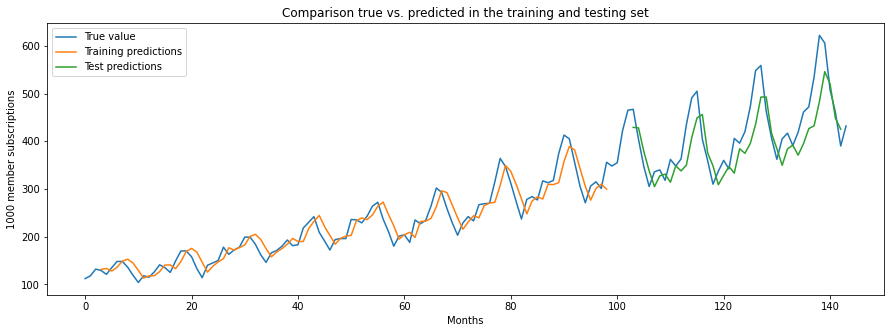

In [13]:
# Training predictions.
train_predictions3 = np.empty_like(dataset)
train_predictions3[:, :] = np.nan
train_predictions3[window_size:len(train_predict) + window_size, :] = train_predict

# Test predictions.
test_predictions3 = np.empty_like(dataset)
test_predictions3[:, :] = np.nan
test_predictions3[len(train_predict) + (window_size * 2) + 1:len(dataset) - 1, :] = test_predict

# Create the plot.
plt.figure(figsize = (15, 5))
plt.plot(normalizer.inverse_transform(dataset), label = "True value")

plt.plot(train_predictions3, label = "Training predictions")
plt.plot(test_predictions3, label = "Test predictions")
plt.xlabel("Months")
plt.ylabel("1000 member subscriptions")
plt.title("Comparison true vs. predicted in the training and testing set")
plt.legend()
plt.show()

# **4**

In [14]:
window_size = 4

# convert pandas data frame in numpy array of float.
data_np = data.values.astype("float32")

# normalize data with min max normalization
normalizer = MinMaxScaler(feature_range = (0, 1))
dataset = normalizer.fit_transform(data_np)

# Using 70% of data for training, 30% for test.
TRAINING_PERC = 0.70

train_size = int(len(dataset) * TRAINING_PERC)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size, :], dataset[train_size:len(dataset), :]
print("Number of samples training set: " + str((len(train))))
print("Number of samples test set: " + str((len(test))))

# Create test and training sets for regression with different window sizes.
train_X, train_Y = create_dataset(train, window_size)
test_X, test_Y = create_dataset(test, window_size)

train_X = np.reshape(train_X, (train_X.shape[0], train_X.shape[1], 1))
test_X = np.reshape(test_X, (test_X.shape[0], test_X.shape[1], 1))

print("Shape of training inputs: " + str((train_X.shape)))
print("Shape of training labels: " + str((train_Y.shape)))

batch_size = 32
rnn = Sequential()    
rnn.add(LSTM(16, input_shape = (window_size, 1)))
rnn.add(Dense(1))
rnn.compile(loss = "mean_squared_error",  optimizer = "adam", metrics = ['mse'])

rnn.fit(train_X, train_Y, epochs=500, batch_size=batch_size, validation_data=(test_X, test_Y))

mse_train, train_predict = get_predict_and_score(rnn, train_X, train_Y, normalizer)
mse_test, test_predict = get_predict_and_score(rnn, test_X, test_Y, normalizer)

print("Training data error: %.2f MSE" % mse_train)
print("Test data error: %.2f MSE" % mse_test)

Number of samples training set: 100
Number of samples test set: 44
Shape of training inputs: (95, 4, 1)
Shape of training labels: (95,)
Epoch 1/500
3/3 [==============================] - 2s 211ms/step - loss: 0.0714 - mse: 0.0714 - val_loss: 0.3820 - val_mse: 0.3820
Epoch 2/500
3/3 [==============================] - 0s 17ms/step - loss: 0.0643 - mse: 0.0643 - val_loss: 0.3568 - val_mse: 0.3568
Epoch 3/500
3/3 [==============================] - 0s 17ms/step - loss: 0.0586 - mse: 0.0586 - val_loss: 0.3324 - val_mse: 0.3324
Epoch 4/500
3/3 [==============================] - 0s 18ms/step - loss: 0.0525 - mse: 0.0525 - val_loss: 0.3095 - val_mse: 0.3095
Epoch 5/500
3/3 [==============================] - 0s 16ms/step - loss: 0.0472 - mse: 0.0472 - val_loss: 0.2875 - val_mse: 0.2875
Epoch 6/500
3/3 [==============================] - 0s 17ms/step - loss: 0.0424 - mse: 0.0424 - val_loss: 0.2664 - val_mse: 0.2664
Epoch 7/500
3/3 [==============================] - 0s 17ms/step - loss: 0.0379 - ms

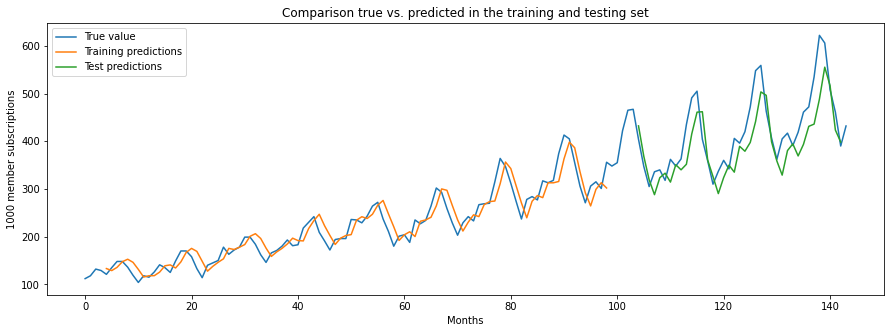

In [15]:
# Training predictions.
train_predictions4 = np.empty_like(dataset)
train_predictions4[:, :] = np.nan
train_predictions4[window_size:len(train_predict) + window_size, :] = train_predict

# Test predictions.
test_predictions4 = np.empty_like(dataset)
test_predictions4[:, :] = np.nan
test_predictions4[len(train_predict) + (window_size * 2) + 1:len(dataset) - 1, :] = test_predict

# Create the plot.
plt.figure(figsize = (15, 5))
plt.plot(normalizer.inverse_transform(dataset), label = "True value")

plt.plot(train_predictions4, label = "Training predictions")
plt.plot(test_predictions4, label = "Test predictions")
plt.xlabel("Months")
plt.ylabel("1000 member subscriptions")
plt.title("Comparison true vs. predicted in the training and testing set")
plt.legend()
plt.show()

# **5**

In [16]:
window_size = 5

# convert pandas data frame in numpy array of float.
data_np = data.values.astype("float32")

# normalize data with min max normalization
normalizer = MinMaxScaler(feature_range = (0, 1))
dataset = normalizer.fit_transform(data_np)

# Using 70% of data for training, 30% for test.
TRAINING_PERC = 0.70

train_size = int(len(dataset) * TRAINING_PERC)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size, :], dataset[train_size:len(dataset), :]
print("Number of samples training set: " + str((len(train))))
print("Number of samples test set: " + str((len(test))))

# Create test and training sets for regression with different window sizes.
train_X, train_Y = create_dataset(train, window_size)
test_X, test_Y = create_dataset(test, window_size)

train_X = np.reshape(train_X, (train_X.shape[0], train_X.shape[1], 1))
test_X = np.reshape(test_X, (test_X.shape[0], test_X.shape[1], 1))

print("Shape of training inputs: " + str((train_X.shape)))
print("Shape of training labels: " + str((train_Y.shape)))

batch_size = 32
rnn = Sequential()    
rnn.add(LSTM(16, input_shape = (window_size, 1)))
rnn.add(Dense(1))
rnn.compile(loss = "mean_squared_error",  optimizer = "adam", metrics = ['mse'])

rnn.fit(train_X, train_Y, epochs=500, batch_size=batch_size, validation_data=(test_X, test_Y))

mse_train, train_predict = get_predict_and_score(rnn, train_X, train_Y, normalizer)
mse_test, test_predict = get_predict_and_score(rnn, test_X, test_Y, normalizer)

print("Training data error: %.2f MSE" % mse_train)
print("Test data error: %.2f MSE" % mse_test)

Number of samples training set: 100
Number of samples test set: 44
Shape of training inputs: (94, 5, 1)
Shape of training labels: (94,)
Epoch 1/500
3/3 [==============================] - 3s 227ms/step - loss: 0.0902 - mse: 0.0902 - val_loss: 0.4797 - val_mse: 0.4797
Epoch 2/500
3/3 [==============================] - 0s 20ms/step - loss: 0.0803 - mse: 0.0803 - val_loss: 0.4435 - val_mse: 0.4435
Epoch 3/500
3/3 [==============================] - 0s 28ms/step - loss: 0.0714 - mse: 0.0714 - val_loss: 0.4089 - val_mse: 0.4089
Epoch 4/500
3/3 [==============================] - 0s 17ms/step - loss: 0.0630 - mse: 0.0630 - val_loss: 0.3758 - val_mse: 0.3758
Epoch 5/500
3/3 [==============================] - 0s 19ms/step - loss: 0.0550 - mse: 0.0550 - val_loss: 0.3444 - val_mse: 0.3444
Epoch 6/500
3/3 [==============================] - 0s 18ms/step - loss: 0.0485 - mse: 0.0485 - val_loss: 0.3142 - val_mse: 0.3142
Epoch 7/500
3/3 [==============================] - 0s 27ms/step - loss: 0.0418 - ms

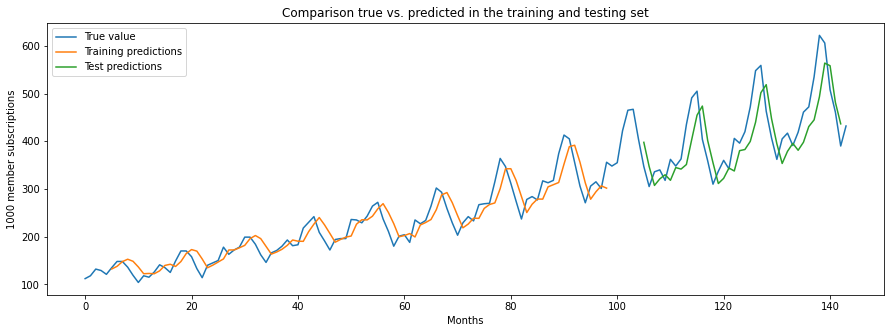

In [17]:
# Training predictions.
train_predictions5 = np.empty_like(dataset)
train_predictions5[:, :] = np.nan
train_predictions5[window_size:len(train_predict) + window_size, :] = train_predict

# Test predictions.
test_predictions5 = np.empty_like(dataset)
test_predictions5[:, :] = np.nan
test_predictions5[len(train_predict) + (window_size * 2) + 1:len(dataset) - 1, :] = test_predict

# Create the plot.
plt.figure(figsize = (15, 5))
plt.plot(normalizer.inverse_transform(dataset), label = "True value")

plt.plot(train_predictions5, label = "Training predictions")
plt.plot(test_predictions5, label = "Test predictions")
plt.xlabel("Months")
plt.ylabel("1000 member subscriptions")
plt.title("Comparison true vs. predicted in the training and testing set")
plt.legend()
plt.show()

# **8**

In [18]:
window_size = 8

# convert pandas data frame in numpy array of float.
data_np = data.values.astype("float32")

# normalize data with min max normalization
normalizer = MinMaxScaler(feature_range = (0, 1))
dataset = normalizer.fit_transform(data_np)

# Using 70% of data for training, 30% for test.
TRAINING_PERC = 0.70

train_size = int(len(dataset) * TRAINING_PERC)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size, :], dataset[train_size:len(dataset), :]
print("Number of samples training set: " + str((len(train))))
print("Number of samples test set: " + str((len(test))))

# Create test and training sets for regression with different window sizes.
train_X, train_Y = create_dataset(train, window_size)
test_X, test_Y = create_dataset(test, window_size)

train_X = np.reshape(train_X, (train_X.shape[0], train_X.shape[1], 1))
test_X = np.reshape(test_X, (test_X.shape[0], test_X.shape[1], 1))

print("Shape of training inputs: " + str((train_X.shape)))
print("Shape of training labels: " + str((train_Y.shape)))

batch_size = 32
rnn = Sequential()    
rnn.add(LSTM(16, input_shape = (window_size, 1)))
rnn.add(Dense(1))
rnn.compile(loss = "mean_squared_error",  optimizer = "adam", metrics = ['mse'])

rnn.fit(train_X, train_Y, epochs=500, batch_size=batch_size, validation_data=(test_X, test_Y))

mse_train, train_predict = get_predict_and_score(rnn, train_X, train_Y, normalizer)
mse_test, test_predict = get_predict_and_score(rnn, test_X, test_Y, normalizer)

print("Training data error: %.2f MSE" % mse_train)
print("Test data error: %.2f MSE" % mse_test)

Number of samples training set: 100
Number of samples test set: 44
Shape of training inputs: (91, 8, 1)
Shape of training labels: (91,)
Epoch 1/500
3/3 [==============================] - 5s 354ms/step - loss: 0.0721 - mse: 0.0721 - val_loss: 0.3767 - val_mse: 0.3767
Epoch 2/500
3/3 [==============================] - 0s 40ms/step - loss: 0.0617 - mse: 0.0617 - val_loss: 0.3353 - val_mse: 0.3353
Epoch 3/500
3/3 [==============================] - 0s 49ms/step - loss: 0.0522 - mse: 0.0522 - val_loss: 0.2960 - val_mse: 0.2960
Epoch 4/500
3/3 [==============================] - 0s 42ms/step - loss: 0.0439 - mse: 0.0439 - val_loss: 0.2584 - val_mse: 0.2584
Epoch 5/500
3/3 [==============================] - 0s 39ms/step - loss: 0.0356 - mse: 0.0356 - val_loss: 0.2231 - val_mse: 0.2231
Epoch 6/500
3/3 [==============================] - 0s 36ms/step - loss: 0.0287 - mse: 0.0287 - val_loss: 0.1897 - val_mse: 0.1897
Epoch 7/500
3/3 [==============================] - 0s 37ms/step - loss: 0.0230 - ms

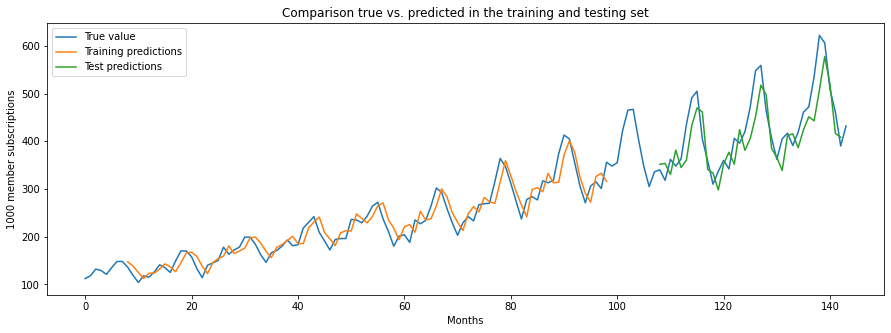

In [19]:
# Training predictions.
train_predictions8 = np.empty_like(dataset)
train_predictions8[:, :] = np.nan
train_predictions8[window_size:len(train_predict) + window_size, :] = train_predict

# Test predictions.
test_predictions8 = np.empty_like(dataset)
test_predictions8[:, :] = np.nan
test_predictions8[len(train_predict) + (window_size * 2) + 1:len(dataset) - 1, :] = test_predict

# Create the plot.
plt.figure(figsize = (15, 5))
plt.plot(normalizer.inverse_transform(dataset), label = "True value")

plt.plot(train_predictions8, label = "Training predictions")
plt.plot(test_predictions8, label = "Test predictions")
plt.xlabel("Months")
plt.ylabel("1000 member subscriptions")
plt.title("Comparison true vs. predicted in the training and testing set")
plt.legend()
plt.show()

# **10**

In [21]:
window_size = 10

# convert pandas data frame in numpy array of float.
data_np = data.values.astype("float32")

# normalize data with min max normalization
normalizer = MinMaxScaler(feature_range = (0, 1))
dataset = normalizer.fit_transform(data_np)

# Using 70% of data for training, 30% for test.
TRAINING_PERC = 0.70

train_size = int(len(dataset) * TRAINING_PERC)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size, :], dataset[train_size:len(dataset), :]
print("Number of samples training set: " + str((len(train))))
print("Number of samples test set: " + str((len(test))))

# Create test and training sets for regression with different window sizes.
train_X, train_Y = create_dataset(train, window_size)
test_X, test_Y = create_dataset(test, window_size)

train_X = np.reshape(train_X, (train_X.shape[0], train_X.shape[1], 1))
test_X = np.reshape(test_X, (test_X.shape[0], test_X.shape[1], 1))

print("Shape of training inputs: " + str((train_X.shape)))
print("Shape of training labels: " + str((train_Y.shape)))

batch_size = 32
rnn = Sequential()    
rnn.add(LSTM(16, input_shape = (window_size, 1)))
rnn.add(Dense(1))
rnn.compile(loss = "mean_squared_error",  optimizer = "adam", metrics = ['mse'])

rnn.fit(train_X, train_Y, epochs=500, batch_size=batch_size, validation_data=(test_X, test_Y))

mse_train, train_predict = get_predict_and_score(rnn, train_X, train_Y, normalizer)
mse_test, test_predict = get_predict_and_score(rnn, test_X, test_Y, normalizer)

print("Training data error: %.2f MSE" % mse_train)
print("Test data error: %.2f MSE" % mse_test)

Number of samples training set: 100
Number of samples test set: 44
Shape of training inputs: (89, 10, 1)
Shape of training labels: (89,)
Epoch 1/500
3/3 [==============================] - 4s 517ms/step - loss: 0.0352 - mse: 0.0352 - val_loss: 0.1782 - val_mse: 0.1782
Epoch 2/500
3/3 [==============================] - 0s 50ms/step - loss: 0.0264 - mse: 0.0264 - val_loss: 0.1431 - val_mse: 0.1431
Epoch 3/500
3/3 [==============================] - 0s 48ms/step - loss: 0.0197 - mse: 0.0197 - val_loss: 0.1121 - val_mse: 0.1121
Epoch 4/500
3/3 [==============================] - 0s 68ms/step - loss: 0.0139 - mse: 0.0139 - val_loss: 0.0860 - val_mse: 0.0860
Epoch 5/500
3/3 [==============================] - 0s 74ms/step - loss: 0.0095 - mse: 0.0095 - val_loss: 0.0648 - val_mse: 0.0648
Epoch 6/500
3/3 [==============================] - 0s 23ms/step - loss: 0.0071 - mse: 0.0071 - val_loss: 0.0484 - val_mse: 0.0484
Epoch 7/500
3/3 [==============================] - 0s 23ms/step - loss: 0.0059 - m

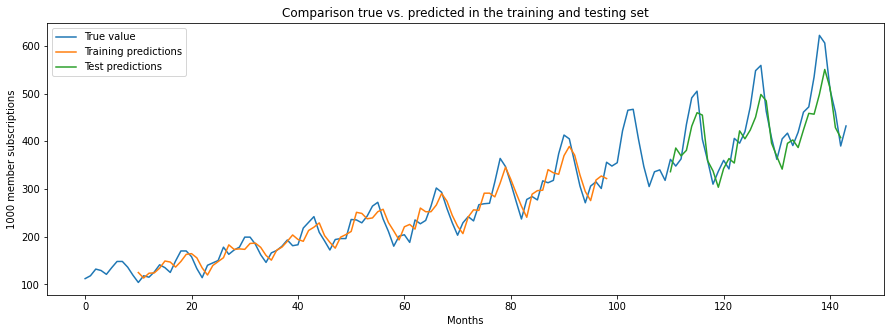

In [22]:
# Training predictions.
train_predictions10 = np.empty_like(dataset)
train_predictions10[:, :] = np.nan
train_predictions10[window_size:len(train_predict) + window_size, :] = train_predict

# Test predictions.
test_predictions10 = np.empty_like(dataset)
test_predictions10[:, :] = np.nan
test_predictions10[len(train_predict) + (window_size * 2) + 1:len(dataset) - 1, :] = test_predict

# Create the plot.
plt.figure(figsize = (15, 5))
plt.plot(normalizer.inverse_transform(dataset), label = "True value")

plt.plot(train_predictions10, label = "Training predictions")
plt.plot(test_predictions10, label = "Test predictions")
plt.xlabel("Months")
plt.ylabel("1000 member subscriptions")
plt.title("Comparison true vs. predicted in the training and testing set")
plt.legend()
plt.show()

#**20**

In [25]:
window_size = 20

# convert pandas data frame in numpy array of float.
data_np = data.values.astype("float32")

# normalize data with min max normalization
normalizer = MinMaxScaler(feature_range = (0, 1))
dataset = normalizer.fit_transform(data_np)

# Using 70% of data for training, 30% for test.
TRAINING_PERC = 0.70

train_size = int(len(dataset) * TRAINING_PERC)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size, :], dataset[train_size:len(dataset), :]
print("Number of samples training set: " + str((len(train))))
print("Number of samples test set: " + str((len(test))))

# Create test and training sets for regression with different window sizes.
train_X, train_Y = create_dataset(train, window_size)
test_X, test_Y = create_dataset(test, window_size)

train_X = np.reshape(train_X, (train_X.shape[0], train_X.shape[1], 1))
test_X = np.reshape(test_X, (test_X.shape[0], test_X.shape[1], 1))

print("Shape of training inputs: " + str((train_X.shape)))
print("Shape of training labels: " + str((train_Y.shape)))

batch_size = 32
rnn = Sequential()    
rnn.add(LSTM(16, input_shape = (window_size, 1)))
rnn.add(Dense(1))
rnn.compile(loss = "mean_squared_error",  optimizer = "adam", metrics = ['mse'])

rnn.fit(train_X, train_Y, epochs=500, batch_size=batch_size, validation_data=(test_X, test_Y))

mse_train, train_predict = get_predict_and_score(rnn, train_X, train_Y, normalizer)
mse_test, test_predict = get_predict_and_score(rnn, test_X, test_Y, normalizer)

print("Training data error: %.2f MSE" % mse_train)
print("Test data error: %.2f MSE" % mse_test)

Number of samples training set: 100
Number of samples test set: 44
Shape of training inputs: (79, 20, 1)
Shape of training labels: (79,)
Epoch 1/500
3/3 [==============================] - 2s 229ms/step - loss: 0.0674 - mse: 0.0674 - val_loss: 0.3424 - val_mse: 0.3424
Epoch 2/500
3/3 [==============================] - 0s 24ms/step - loss: 0.0529 - mse: 0.0529 - val_loss: 0.2822 - val_mse: 0.2822
Epoch 3/500
3/3 [==============================] - 0s 23ms/step - loss: 0.0397 - mse: 0.0397 - val_loss: 0.2260 - val_mse: 0.2260
Epoch 4/500
3/3 [==============================] - 0s 23ms/step - loss: 0.0282 - mse: 0.0282 - val_loss: 0.1744 - val_mse: 0.1744
Epoch 5/500
3/3 [==============================] - 0s 22ms/step - loss: 0.0185 - mse: 0.0185 - val_loss: 0.1281 - val_mse: 0.1281
Epoch 6/500
3/3 [==============================] - 0s 23ms/step - loss: 0.0114 - mse: 0.0114 - val_loss: 0.0887 - val_mse: 0.0887
Epoch 7/500
3/3 [==============================] - 0s 26ms/step - loss: 0.0074 - m

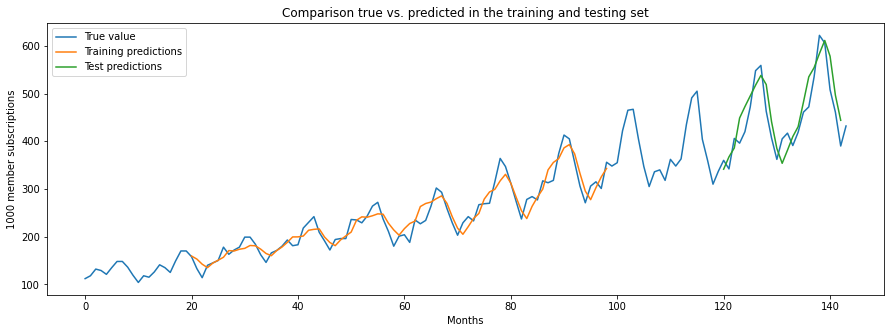

In [26]:
# Training predictions.
train_predictions20 = np.empty_like(dataset)
train_predictions20[:, :] = np.nan
train_predictions20[window_size:len(train_predict) + window_size, :] = train_predict

# Test predictions.
test_predictions20 = np.empty_like(dataset)
test_predictions20[:, :] = np.nan
test_predictions20[len(train_predict) + (window_size * 2) + 1:len(dataset) - 1, :] = test_predict

# Create the plot.
plt.figure(figsize = (15, 5))
plt.plot(normalizer.inverse_transform(dataset), label = "True value")

plt.plot(train_predictions20, label = "Training predictions")
plt.plot(test_predictions20, label = "Test predictions")
plt.xlabel("Months")
plt.ylabel("1000 member subscriptions")
plt.title("Comparison true vs. predicted in the training and testing set")
plt.legend()
plt.show()

# **22**

In [36]:
window_size = 22

# convert pandas data frame in numpy array of float.
data_np = data.values.astype("float32")

# normalize data with min max normalization
normalizer = MinMaxScaler(feature_range = (0, 1))
dataset = normalizer.fit_transform(data_np)

# Using 70% of data for training, 30% for test.
TRAINING_PERC = 0.70

train_size = int(len(dataset) * TRAINING_PERC)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size, :], dataset[train_size:len(dataset), :]
print("Number of samples training set: " + str((len(train))))
print("Number of samples test set: " + str((len(test))))

# Create test and training sets for regression with different window sizes.
train_X, train_Y = create_dataset(train, window_size)
test_X, test_Y = create_dataset(test, window_size)

train_X = np.reshape(train_X, (train_X.shape[0], train_X.shape[1], 1))
test_X = np.reshape(test_X, (test_X.shape[0], test_X.shape[1], 1))

print("Shape of training inputs: " + str((train_X.shape)))
print("Shape of training labels: " + str((train_Y.shape)))

batch_size = 32
rnn = Sequential()    
rnn.add(LSTM(16, input_shape = (window_size, 1)))
rnn.add(Dense(1))
rnn.compile(loss = "mean_squared_error",  optimizer = "adam", metrics = ['mse'])

rnn.fit(train_X, train_Y, epochs=500, batch_size=batch_size, validation_data=(test_X, test_Y))

mse_train, train_predict = get_predict_and_score(rnn, train_X, train_Y, normalizer)
mse_test, test_predict = get_predict_and_score(rnn, test_X, test_Y, normalizer)

print("Training data error: %.2f MSE" % mse_train)
print("Test data error: %.2f MSE" % mse_test)

Number of samples training set: 100
Number of samples test set: 44
Shape of training inputs: (77, 22, 1)
Shape of training labels: (77,)
Epoch 1/500
3/3 [==============================] - 3s 428ms/step - loss: 0.0162 - mse: 0.0162 - val_loss: 0.0858 - val_mse: 0.0858
Epoch 2/500
3/3 [==============================] - 0s 44ms/step - loss: 0.0091 - mse: 0.0091 - val_loss: 0.0541 - val_mse: 0.0541
Epoch 3/500
3/3 [==============================] - 0s 35ms/step - loss: 0.0050 - mse: 0.0050 - val_loss: 0.0338 - val_mse: 0.0338
Epoch 4/500
3/3 [==============================] - 0s 25ms/step - loss: 0.0048 - mse: 0.0048 - val_loss: 0.0246 - val_mse: 0.0246
Epoch 5/500
3/3 [==============================] - 0s 26ms/step - loss: 0.0059 - mse: 0.0059 - val_loss: 0.0234 - val_mse: 0.0234
Epoch 6/500
3/3 [==============================] - 0s 26ms/step - loss: 0.0058 - mse: 0.0058 - val_loss: 0.0264 - val_mse: 0.0264
Epoch 7/500
3/3 [==============================] - 0s 27ms/step - loss: 0.0048 - m

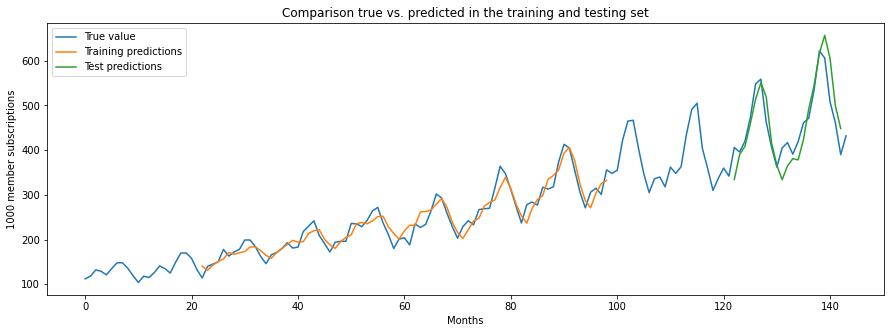

In [37]:
# Training predictions.
train_predictions22 = np.empty_like(dataset)
train_predictions22[:, :] = np.nan
train_predictions22[window_size:len(train_predict) + window_size, :] = train_predict

# Test predictions.
test_predictions22 = np.empty_like(dataset)
test_predictions22[:, :] = np.nan
test_predictions22[len(train_predict) + (window_size * 2) + 1:len(dataset) - 1, :] = test_predict

# Create the plot.
plt.figure(figsize = (15, 5))
plt.plot(normalizer.inverse_transform(dataset), label = "True value")

plt.plot(train_predictions22, label = "Training predictions")
plt.plot(test_predictions22, label = "Test predictions")
plt.xlabel("Months")
plt.ylabel("1000 member subscriptions")
plt.title("Comparison true vs. predicted in the training and testing set")
plt.legend()
plt.show()

# **30**

In [34]:
window_size = 30

# convert pandas data frame in numpy array of float.
data_np = data.values.astype("float32")

# normalize data with min max normalization
normalizer = MinMaxScaler(feature_range = (0, 1))
dataset = normalizer.fit_transform(data_np)

# Using 70% of data for training, 30% for test.
TRAINING_PERC = 0.70

train_size = int(len(dataset) * TRAINING_PERC)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size, :], dataset[train_size:len(dataset), :]
print("Number of samples training set: " + str((len(train))))
print("Number of samples test set: " + str((len(test))))

# Create test and training sets for regression with different window sizes.
train_X, train_Y = create_dataset(train, window_size)
test_X, test_Y = create_dataset(test, window_size)

train_X = np.reshape(train_X, (train_X.shape[0], train_X.shape[1], 1))
test_X = np.reshape(test_X, (test_X.shape[0], test_X.shape[1], 1))

print("Shape of training inputs: " + str((train_X.shape)))
print("Shape of training labels: " + str((train_Y.shape)))

batch_size = 32
rnn = Sequential()    
rnn.add(LSTM(16, input_shape = (window_size, 1)))
rnn.add(Dense(1))
rnn.compile(loss = "mean_squared_error",  optimizer = "adam", metrics = ['mse'])

rnn.fit(train_X, train_Y, epochs=500, batch_size=batch_size, validation_data=(test_X, test_Y))

mse_train, train_predict = get_predict_and_score(rnn, train_X, train_Y, normalizer)
mse_test, test_predict = get_predict_and_score(rnn, test_X, test_Y, normalizer)

print("Training data error: %.2f MSE" % mse_train)
print("Test data error: %.2f MSE" % mse_test)

Number of samples training set: 100
Number of samples test set: 44
Shape of training inputs: (69, 30, 1)
Shape of training labels: (69,)
Epoch 1/500
3/3 [==============================] - 3s 260ms/step - loss: 0.1344 - mse: 0.1344 - val_loss: 0.6504 - val_mse: 0.6504
Epoch 2/500
3/3 [==============================] - 0s 32ms/step - loss: 0.1087 - mse: 0.1087 - val_loss: 0.5513 - val_mse: 0.5513
Epoch 3/500
3/3 [==============================] - 0s 29ms/step - loss: 0.0878 - mse: 0.0878 - val_loss: 0.4640 - val_mse: 0.4640
Epoch 4/500
3/3 [==============================] - 0s 30ms/step - loss: 0.0698 - mse: 0.0698 - val_loss: 0.3886 - val_mse: 0.3886
Epoch 5/500
3/3 [==============================] - 0s 28ms/step - loss: 0.0547 - mse: 0.0547 - val_loss: 0.3237 - val_mse: 0.3237
Epoch 6/500
3/3 [==============================] - 0s 29ms/step - loss: 0.0421 - mse: 0.0421 - val_loss: 0.2661 - val_mse: 0.2661
Epoch 7/500
3/3 [==============================] - 0s 29ms/step - loss: 0.0316 - m

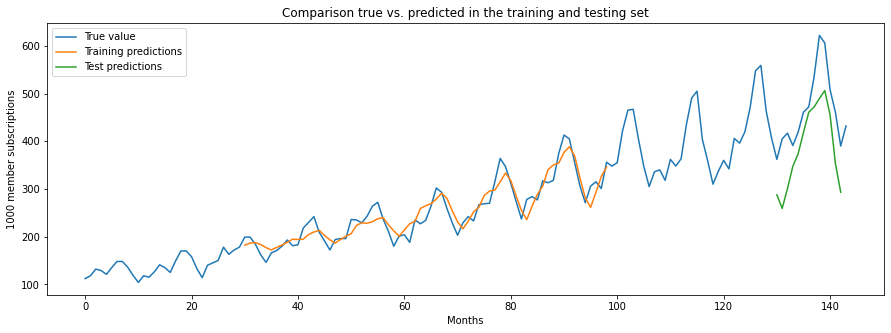

In [35]:
# Training predictions.
train_predictions30 = np.empty_like(dataset)
train_predictions30[:, :] = np.nan
train_predictions30[window_size:len(train_predict) + window_size, :] = train_predict

# Test predictions.
test_predictions30 = np.empty_like(dataset)
test_predictions30[:, :] = np.nan
test_predictions30[len(train_predict) + (window_size * 2) + 1:len(dataset) - 1, :] = test_predict

# Create the plot.
plt.figure(figsize = (15, 5))
plt.plot(normalizer.inverse_transform(dataset), label = "True value")

plt.plot(train_predictions30, label = "Training predictions")
plt.plot(test_predictions30, label = "Test predictions")
plt.xlabel("Months")
plt.ylabel("1000 member subscriptions")
plt.title("Comparison true vs. predicted in the training and testing set")
plt.legend()
plt.show()

# **40**

In [28]:
window_size = 40

# convert pandas data frame in numpy array of float.
data_np = data.values.astype("float32")

# normalize data with min max normalization
normalizer = MinMaxScaler(feature_range = (0, 1))
dataset = normalizer.fit_transform(data_np)

# Using 70% of data for training, 30% for test.
TRAINING_PERC = 0.70

train_size = int(len(dataset) * TRAINING_PERC)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size, :], dataset[train_size:len(dataset), :]
print("Number of samples training set: " + str((len(train))))
print("Number of samples test set: " + str((len(test))))

# Create test and training sets for regression with different window sizes.
train_X, train_Y = create_dataset(train, window_size)
test_X, test_Y = create_dataset(test, window_size)

train_X = np.reshape(train_X, (train_X.shape[0], train_X.shape[1], 1))
test_X = np.reshape(test_X, (test_X.shape[0], test_X.shape[1], 1))

print("Shape of training inputs: " + str((train_X.shape)))
print("Shape of training labels: " + str((train_Y.shape)))

batch_size = 32
rnn = Sequential()    
rnn.add(LSTM(16, input_shape = (window_size, 1)))
rnn.add(Dense(1))
rnn.compile(loss = "mean_squared_error",  optimizer = "adam", metrics = ['mse'])

rnn.fit(train_X, train_Y, epochs=500, batch_size=batch_size, validation_data=(test_X, test_Y))

mse_train, train_predict = get_predict_and_score(rnn, train_X, train_Y, normalizer)
mse_test, test_predict = get_predict_and_score(rnn, test_X, test_Y, normalizer)

print("Training data error: %.2f MSE" % mse_train)
print("Test data error: %.2f MSE" % mse_test)

Number of samples training set: 100
Number of samples test set: 44
Shape of training inputs: (59, 40, 1)
Shape of training labels: (59,)
Epoch 1/500
2/2 [==============================] - 2s 492ms/step - loss: 0.2022 - mse: 0.2022 - val_loss: 0.9175 - val_mse: 0.9175
Epoch 2/500
2/2 [==============================] - 0s 47ms/step - loss: 0.1798 - mse: 0.1798 - val_loss: 0.8392 - val_mse: 0.8392
Epoch 3/500
2/2 [==============================] - 0s 49ms/step - loss: 0.1605 - mse: 0.1605 - val_loss: 0.7671 - val_mse: 0.7671
Epoch 4/500
2/2 [==============================] - 0s 46ms/step - loss: 0.1419 - mse: 0.1419 - val_loss: 0.7003 - val_mse: 0.7003
Epoch 5/500
2/2 [==============================] - 0s 44ms/step - loss: 0.1254 - mse: 0.1254 - val_loss: 0.6376 - val_mse: 0.6376
Epoch 6/500
2/2 [==============================] - 0s 45ms/step - loss: 0.1097 - mse: 0.1097 - val_loss: 0.5785 - val_mse: 0.5785
Epoch 7/500
2/2 [==============================] - 0s 46ms/step - loss: 0.0956 - m

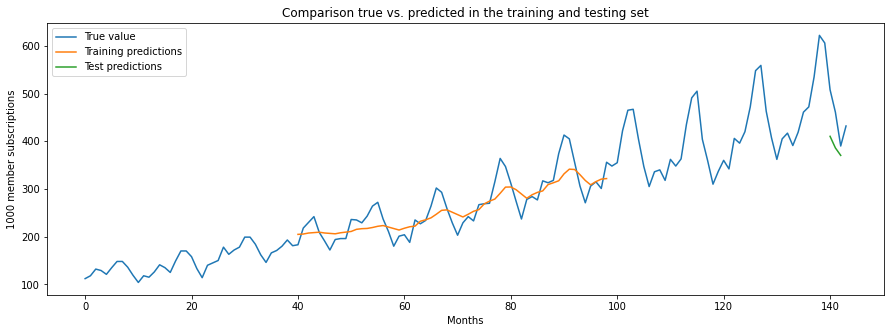

In [29]:
# Training predictions.
train_predictions40 = np.empty_like(dataset)
train_predictions40[:, :] = np.nan
train_predictions40[window_size:len(train_predict) + window_size, :] = train_predict

# Test predictions.
test_predictions40 = np.empty_like(dataset)
test_predictions40[:, :] = np.nan
test_predictions40[len(train_predict) + (window_size * 2) + 1:len(dataset) - 1, :] = test_predict

# Create the plot.
plt.figure(figsize = (15, 5))
plt.plot(normalizer.inverse_transform(dataset), label = "True value")

plt.plot(train_predictions40, label = "Training predictions")
plt.plot(test_predictions40, label = "Test predictions")
plt.xlabel("Months")
plt.ylabel("1000 member subscriptions")
plt.title("Comparison true vs. predicted in the training and testing set")
plt.legend()
plt.show()

# **Compare**

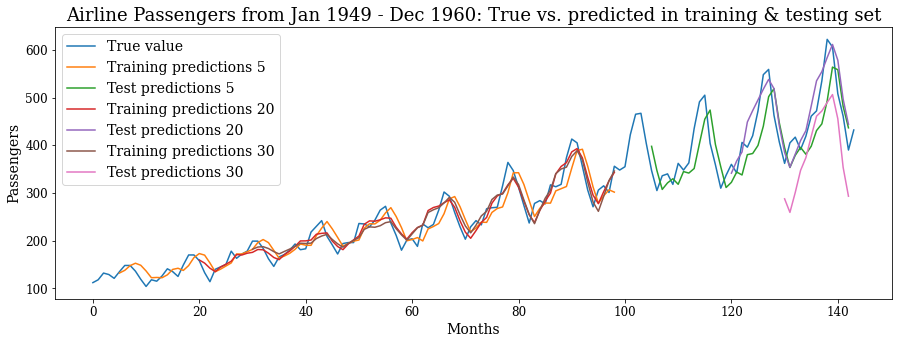

In [63]:
plt.figure(figsize = (15, 5))
plt.plot(normalizer.inverse_transform(dataset), label = "True value")

plt.plot(train_predictions5, label = "Training predictions 5")
plt.plot(test_predictions5, label = "Test predictions 5")
plt.plot(train_predictions20, label = "Training predictions 20")
plt.plot(test_predictions20, label = "Test predictions 20")
plt.plot(train_predictions30, label = "Training predictions 30")
plt.plot(test_predictions30, label = "Test predictions 30")
plt.xlabel("Months", fontsize = 14)
plt.ylabel("Passengers", fontsize = 14)
plt.title("Airline Passengers from Jan 1949 - Dec 1960: True vs. predicted in training & testing set", fontsize = 18)
plt.legend(fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.savefig('/content/drive/MyDrive/dl-cw-05/diagrams/windowsize.png')
plt.show()

# **Task 2**

## Dataset

In [2]:
import tensorflow as tf
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding, Dropout, Flatten
from keras.layers import LSTM, GlobalAvgPool1D
from keras.datasets import imdb
from keras.utils import np_utils, pad_sequences
import numpy as np

# number of most-frequent words to use
nb_words = 5000
n_classes = 1
print('Loading data...')
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=nb_words)
print('x_train:', x_train.shape)
print('x_test:', x_test.shape)
# get_word_index retrieves a mapping word -> index
word_index = imdb.get_word_index()
# We make space for the three special tokens
word_index_c = dict((w, i+3) for (w, i) in word_index.items())
word_index_c['<PAD>'] = 0
word_index_c['<START>'] = 1
word_index_c['<UNK>'] = 2
# Instead of having dictionary word -> index we form
# the dictionary index -> word
index_word = dict((i, w) for (w, i) in word_index_c.items())
# Truncate sentences after this number of words
maxlen = 100
print('Pad sequences (samples x time)')
x_train = pad_sequences(x_train, maxlen=maxlen)
x_test = pad_sequences(x_test, maxlen=maxlen)
print('x_train shape:', x_train.shape)
print('x_test shape:', x_test.shape)

x_val = x_train[23000:]
y_val = y_train[23000:]
x_train = x_train[:23000]
y_train = y_train[:23000]

from keras.callbacks import EarlyStopping

## We train the model for at most 50 epochs
epochs = 50
early_stop = EarlyStopping(
    monitor='val_accuracy',
    min_delta=0,
    patience=10,
    verbose=0,
    mode='auto',
    baseline=None,
    restore_best_weights=True
)

Loading data...
17464789/17464789 [==============================] - 2s 0us/step
x_train: (25000,)
x_test: (25000,)
1641221/1641221 [==============================] - 0s 0us/step
Pad sequences (samples x time)
x_train shape: (25000, 100)
x_test shape: (25000, 100)


## Using embeddings of dimensionality 1, train a model without using any LSTM, only using an average pooling of the input embeddings (called embeddings_model in the code given below).

In [74]:
# Dimensions of the embeddings
embedding_dim = 1

print('Build model...')
embeddings_model = Sequential()

embeddings_model.add(Embedding(nb_words,
                    embedding_dim,
                    input_length=maxlen,
                            trainable=True))
embeddings_model.add(GlobalAvgPool1D())
embeddings_model.add(Dense(1, activation='sigmoid'))
embeddings_model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
print(embeddings_model.summary())

Build model...
Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 100, 1)            5000      
                                                                 
 global_average_pooling1d_1   (None, 1)                0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dense_16 (Dense)            (None, 1)                 2         
                                                                 
Total params: 5,002
Trainable params: 5,002
Non-trainable params: 0
_________________________________________________________________
None


In [76]:
history = embeddings_model.fit(x_train, y_train, batch_size=32, epochs=epochs, callbacks=[early_stop], validation_data=(x_val,y_val))
print('Final test accuracy is:')
embeddings_model.evaluate(x_test, y_test)

Epoch 1/50
719/719 [==============================] - 2s 2ms/step - loss: 0.6877 - accuracy: 0.6528 - val_loss: 0.6767 - val_accuracy: 0.7350
Epoch 2/50
719/719 [==============================] - 2s 2ms/step - loss: 0.6589 - accuracy: 0.7379 - val_loss: 0.6400 - val_accuracy: 0.7375
Epoch 3/50
719/719 [==============================] - 2s 2ms/step - loss: 0.6169 - accuracy: 0.7625 - val_loss: 0.5967 - val_accuracy: 0.7710
Epoch 4/50
719/719 [==============================] - 2s 3ms/step - loss: 0.5732 - accuracy: 0.7828 - val_loss: 0.5570 - val_accuracy: 0.7790
Epoch 5/50
719/719 [==============================] - 2s 3ms/step - loss: 0.5325 - accuracy: 0.8009 - val_loss: 0.5216 - val_accuracy: 0.7920
Epoch 6/50
719/719 [==============================] - 2s 2ms/step - loss: 0.4964 - accuracy: 0.8157 - val_loss: 0.4912 - val_accuracy: 0.7990
Epoch 7/50
719/719 [==============================] - 2s 2ms/step - loss: 0.4650 - accuracy: 0.8272 - val_loss: 0.4657 - val_accuracy: 0.8080
Epoch 

[0.33855336904525757, 0.8518000245094299]

In [78]:
weights = embeddings_model.layers[0].get_weights()[0]
query_word = '8'
dist = ((weights - weights[word_index_c[query_word]])**2).sum(1).argsort()
top_k = 10
print("Embedding value of {:s} is {:f}", query_word, weights[word_index_c[query_word]][0])
print('Most {:d} similar words to {:s}'.format(top_k, query_word))
for k in range(1, top_k+1):
  print("{:d}: {:s}".format(k, index_word[dist[k]]))

Embedding value of {:s} is {:f} 8 -5.9951587
Most 10 similar words to 8
1: excellent
2: highly
3: wonderful
4: perfect
5: recommended
6: 9
7: superb
8: 7
9: unexpected
10: today


In [79]:
negative_review = "the movie is boring and not good"
words = negative_review.split()
seq_input = [word_index_c[w] for w in words]
seq_input = np.array([seq_input])
seq_input = pad_sequences(seq_input,maxlen=100)
negative_review_score = embeddings_model.predict(seq_input)

positive_review = "the movie is good and not boring"
words = positive_review.split()
seq_input = [word_index_c[w] for w in words]
seq_input = np.array([seq_input])
seq_input = pad_sequences(seq_input,maxlen=100)
positive_review_score = embeddings_model.predict(seq_input)

print("The score for the negative review is:", negative_review_score)
print("The score for the positive review is:", positive_review_score)

1/1 [==============================] - 0s 25ms/step
The score for the negative review is: [[0.38737437]]
The score for the positive review is: [[0.38737434]]


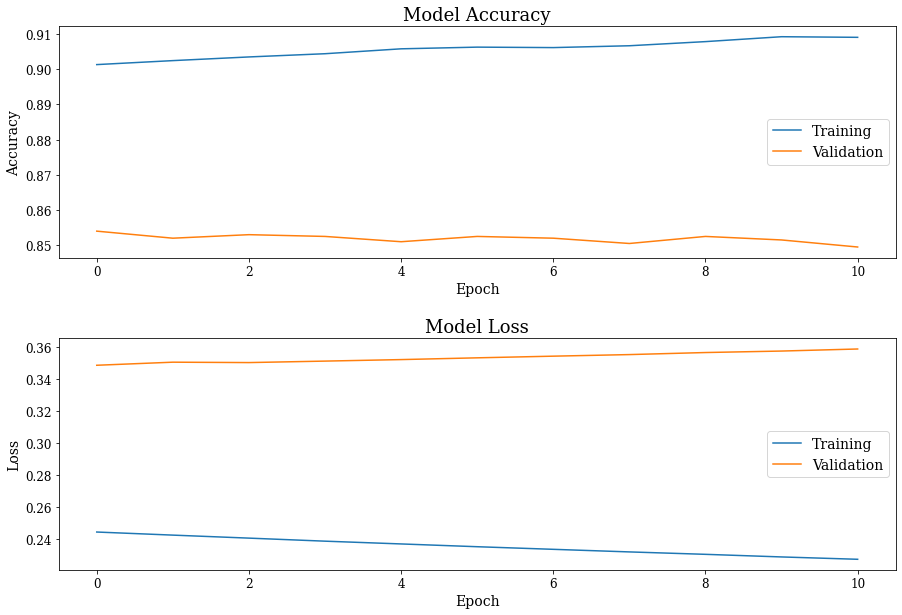

In [99]:
plot_history(history, 'embeddings_dim_1.png', metric='accuracy')

## Model with an LSTM and trainable embeddings initialized at random (called lstm_model)

In [95]:
import random 
     
# Dimensions of the embeddings
embedding_dim = random.randrange(5000)
print(embedding_dim)

print('Build model...')
embeddings_LSTM_model = Sequential()

embeddings_LSTM_model.add(Embedding(nb_words,
                    embedding_dim,
                    input_length=maxlen,
                            trainable=True))

embeddings_LSTM_model.add(LSTM(128))
embeddings_LSTM_model.add(Dense(1, activation='sigmoid'))

embeddings_LSTM_model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
print(embeddings_LSTM_model.summary())

2258
Build model...
Model: "sequential_27"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_11 (Embedding)    (None, 100, 2258)         11290000  
                                                                 
 lstm_23 (LSTM)              (None, 128)               1222144   
                                                                 
 dense_22 (Dense)            (None, 1)                 129       
                                                                 
Total params: 12,512,273
Trainable params: 12,512,273
Non-trainable params: 0
_________________________________________________________________
None


In [96]:
history = embeddings_model.fit(x_train, y_train, batch_size=32, epochs=epochs, callbacks=[early_stop], validation_data=(x_val,y_val))
print('Final test accuracy is:')
embeddings_model.evaluate(x_test, y_test)

Epoch 1/50
719/719 [==============================] - 2s 3ms/step - loss: 0.2445 - accuracy: 0.9013 - val_loss: 0.3488 - val_accuracy: 0.8540
Epoch 2/50
719/719 [==============================] - 2s 3ms/step - loss: 0.2426 - accuracy: 0.9024 - val_loss: 0.3507 - val_accuracy: 0.8520
Epoch 3/50
719/719 [==============================] - 2s 2ms/step - loss: 0.2407 - accuracy: 0.9034 - val_loss: 0.3505 - val_accuracy: 0.8530
Epoch 4/50
719/719 [==============================] - 2s 3ms/step - loss: 0.2388 - accuracy: 0.9043 - val_loss: 0.3514 - val_accuracy: 0.8525
Epoch 5/50
719/719 [==============================] - 2s 3ms/step - loss: 0.2371 - accuracy: 0.9057 - val_loss: 0.3523 - val_accuracy: 0.8510
Epoch 6/50
719/719 [==============================] - 2s 3ms/step - loss: 0.2353 - accuracy: 0.9062 - val_loss: 0.3534 - val_accuracy: 0.8525
Epoch 7/50
719/719 [==============================] - 2s 2ms/step - loss: 0.2337 - accuracy: 0.9061 - val_loss: 0.3545 - val_accuracy: 0.8520
Epoch 

[0.33939817547798157, 0.8525599837303162]

In [97]:
weights = embeddings_model.layers[0].get_weights()[0]
query_word = '8'
dist = ((weights - weights[word_index_c[query_word]])**2).sum(1).argsort()
top_k = 10
print("Embedding value of {:s} is {:f}", query_word, weights[word_index_c[query_word]][0])
print('Most {:d} similar words to {:s}'.format(top_k, query_word))
for k in range(1, top_k+1):
  print("{:d}: {:s}".format(k, index_word[dist[k]]))

negative_review = "the movie is boring and not good"
words = negative_review.split()
seq_input = [word_index_c[w] for w in words]
seq_input = np.array([seq_input])
seq_input = pad_sequences(seq_input,maxlen=100)
negative_review_score = embeddings_model.predict(seq_input)

positive_review = "the movie is good and not boring"
words = positive_review.split()
seq_input = [word_index_c[w] for w in words]
seq_input = np.array([seq_input])
seq_input = pad_sequences(seq_input,maxlen=100)
positive_review_score = embeddings_model.predict(seq_input)

print("The score for the negative review is:", negative_review_score)
print("The score for the positive review is:", positive_review_score)

Embedding value of {:s} is {:f} 8 -6.031965
Most 10 similar words to 8
1: excellent
2: highly
3: wonderful
4: perfect
5: recommended
6: 9
7: 7
8: superb
9: unexpected
10: today
1/1 [==============================] - 0s 26ms/step
The score for the negative review is: [[0.29332408]]
The score for the positive review is: [[0.29332408]]


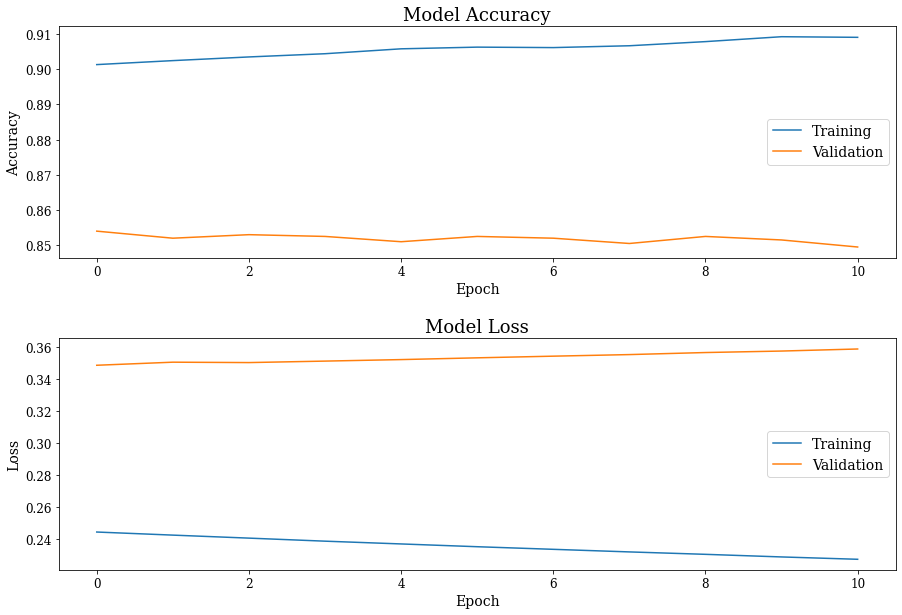

In [100]:
plot_history(history, 'embeddings_lstm_1.png', metric='accuracy')

### Test 2

In [ ]:
## Model parameters:
# Dimensions of the embeddings
embedding_dim = 300

## LSTM dimensionality
lstm_units = 50

print('Build model...')
lstm_model = Sequential()

lstm_model.add(Embedding(nb_words,
                    embedding_dim,
                    input_length=maxlen,
                            trainable=True))
### Do not modify the layers below
lstm_model.add(Dropout(0.2))
lstm_model.add(LSTM(lstm_units, dropout=0.2))
lstm_model.add(Dropout(0.2))
lstm_model.add(Dense(1, activation='sigmoid'))
lstm_model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
print(lstm_model.summary())

history_lstm2 = lstm_model.fit(x_train, y_train, batch_size=32, epochs=epochs, callbacks=[early_stop], validation_data=(x_val,y_val))
print('Final test accuracy is:')
lstm_model.evaluate(x_test, y_test)

Build model...
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 100, 300)          1500000   
                                                                 
 dropout_2 (Dropout)         (None, 100, 300)          0         
                                                                 
 lstm_1 (LSTM)               (None, 50)                70200     
                                                                 
 dropout_3 (Dropout)         (None, 50)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 51        
                                                                 
Total params: 1,570,251
Trainable params: 1,570,251
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/50
719/719 [====

In [ ]:
weights = lstm_model.layers[0].get_weights()[0]
query_word = '8'
dist = ((weights - weights[word_index_c[query_word]])**2).sum(1).argsort()
top_k = 10
print("Embedding value of {:s} is {:f}", query_word, weights[word_index_c[query_word]][0])
print('Most {:d} similar words to {:s}'.format(top_k, query_word))
for k in range(1, top_k+1):
  print("{:d}: {:s}".format(k, index_word[dist[k]]))

negative_review = "the movie is boring and not good"
words = negative_review.split()
seq_input = [word_index_c[w] for w in words]
seq_input = np.array([seq_input])
seq_input = pad_sequences(seq_input,maxlen=100)
negative_review_score = lstm_model.predict(seq_input)

positive_review = "the movie is good and not boring"
words = positive_review.split()
seq_input = [word_index_c[w] for w in words]
seq_input = np.array([seq_input])
seq_input = pad_sequences(seq_input,maxlen=100)
positive_review_score = lstm_model.predict(seq_input)

print("The score for the negative review is:", negative_review_score)
print("The score for the positive review is:", positive_review_score)

In [ ]:
plot_history(history_lstm2, 'embeddings_lstm_2.png', metric='accuracy')

## Model with an LSTM with non-trainable embeddings initialized with GloVe embeddings (called lstm_glove_model)

In [ ]:
!wget https://imperialcollegelondon.box.com/shared/static/c9trfhhwl9ohje5g3sapu3xk2zoywp3c.txt -O gensim_glove_vectors.txt

from gensim.models.keyedvectors import KeyedVectors
glove_model = KeyedVectors.load_word2vec_format("gensim_glove_vectors.txt", binary=False)

import numpy as np
embedding_matrix = np.zeros((nb_words, 300))
for word, i in word_index_c.items():
    if word in glove_model:
      embedding_vector = glove_model[word]
      if embedding_vector is not None and i < nb_words:
          # words not found in embedding index will be all-zeros.
          embedding_matrix[i] = embedding_vector

In [ ]:
from keras.layers.wrappers import Bidirectional
from keras.layers import GlobalMaxPool1D, Flatten, GlobalAvgPool1D, Dropout

## Model parameters:
# Dimensions of the embeddings
embedding_dim = 300

## LSTM dimensionality
lstm_units = 50

print('Build model...')
lstm_glove_model = Sequential()

lstm_glove_model.add(Embedding(nb_words,
                    embedding_dim,
                    input_length=maxlen,
                    weights=[embedding_matrix],
                            trainable=False))
### Do not modify the layers below
lstm_glove_model.add(Dropout(0.2))
lstm_glove_model.add(LSTM(lstm_units, dropout=0.2))
lstm_glove_model.add(Dropout(0.2))
lstm_glove_model.add(Dense(1, activation='sigmoid'))
lstm_glove_model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
print(lstm_glove_model.summary())

history = lstm_glove_model.fit(x_train, y_train, batch_size=32, epochs=epochs, callbacks=[early_stop], validation_data=(x_val,y_val))
print('Final test accuracy is:')
lstm_glove_model.evaluate(x_test, y_test)

query_word = '8'
weights = embedding_matrix

dist = ((weights - weights[word_index_c[query_word]])**2).sum(1).argsort()
top_k = 10
print('Most {:d} similar words to {:s}'.format(top_k, query_word))
for k in range(1, top_k+1):
  print("{:d}: {:s}".format(k, index_word[dist[k]]))